In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

# Versuch 3: Spracherkennung und Fourieranalyse

## Aufgabe 1: Mundharmonika

M: 10004


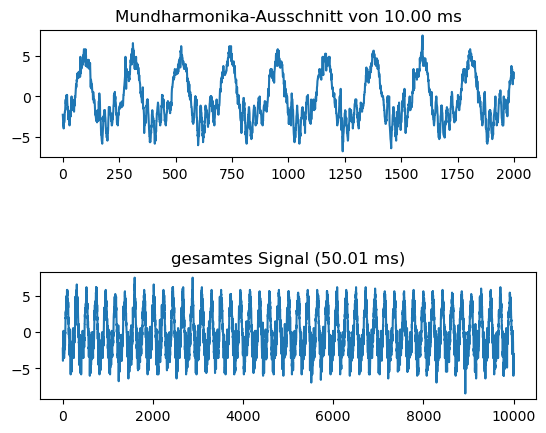

In [199]:
absPath = "D:/,.studium/HTWG/AIN/3/technische-grundlagen-der-kuenstlichen-intelligenz/versuch3"
mundharmonika = pd.read_csv(f"{absPath}/mundharmonika.csv", sep=';', decimal=',', header=1)
mundh = mundharmonika['(mV)']
N = len(mundh)

def dt(x): return mundharmonika['(ms)'][x] - mundharmonika['(ms)'][0]
def dts(x): return dt(x) / 1000

print(f"M: {mundh.size}")
fig, splt = plt.subplots(2)
splt[0].plot(mundh[0:2000])
splt[0].set_title(f'Mundharmonika-Ausschnitt von {dt(2000):.2f} ms')
splt[1].plot(mundh)
splt[1].set_title(f"gesamtes Signal ({dt(mundh.size - 1):.2f} ms)")
plt.subplots_adjust(hspace=0.9)
plt.show()

##### Angaben:
    Abtastpunkte = 10 004 (ca. 10 000)
    Signaldauer = 50.1 ms (ca. 50ms oder 1/20 s)
    Schwingungen = ca. 47 (gezählt)
Abtastzeit = ca. 0,005 ms = 5 µs => Abtastfrequenz = 200 000 Hz <br>
ungefähr 47 Schwingungen in 50 ms => Grundperiodendauer ca. 1.06 ms => Grundfrequenz: ca. 940 Hz


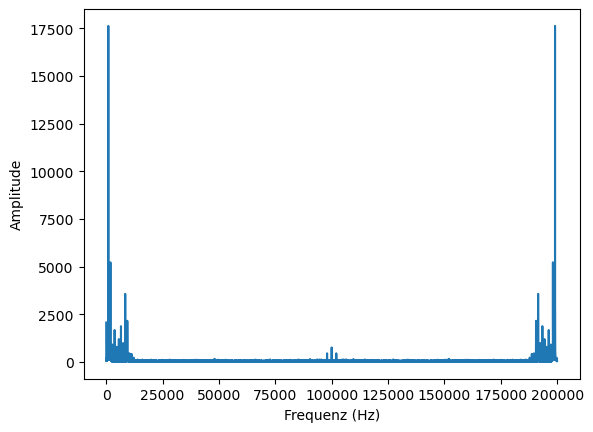

10004
Grundwellenzahl: 47 1/0.051s
Grundfrequenz: 939.6241503393834 Hz


In [49]:
ft = np.abs(np.fft.fft(mundh))
k = np.arange(N)
k = k / (mundh.size * dts(1)) # dts(1) = zeitlicher Abstand zwischen 2 Messpunkten in s
ftFreq = np.fft.fftfreq(mundh.size, 0.000005)
plt.plot(k, ft)
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.show()
print(ft.size)
grundwellenzahl = np.argmax(ft[0:5000])
grundfrequenz = k[grundwellenzahl]
print(f"Grundwellenzahl: {grundwellenzahl} 1/0.051s")
print(f"Grundfrequenz: {grundfrequenz} Hz")

## Aufgabe 2: Blablabla-Signal

#### 2 a) Darstellung des Signals

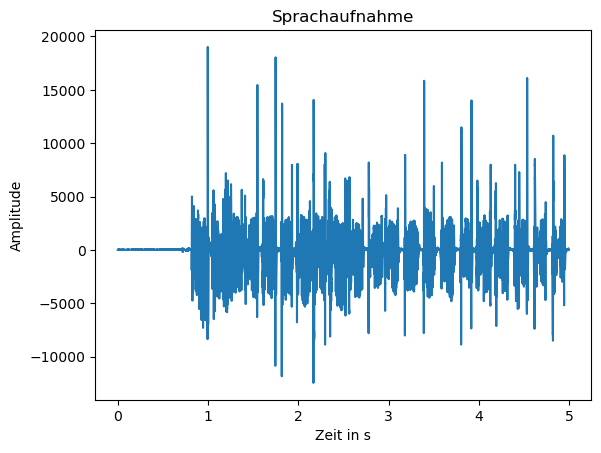

In [59]:
bla = np.load(f"{absPath}/blablabla.npy")
k = np.arange(bla.size)
samples = 44100 # Sample-Rate der Aufnahme
k = k / samples
plt.plot(k, bla)
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.title('Sprachaufnahme')
plt.show()

#### 2 b) Abschneiden eines 1s Schnipsels

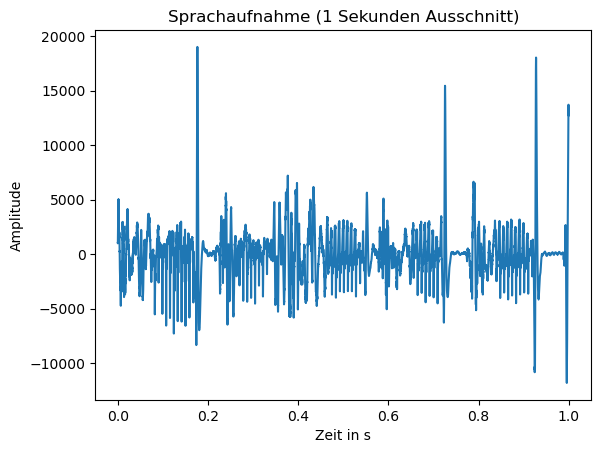

In [86]:
def firstOverVal(arr, grenzw) :
    for a in np.arange(arr.size):
        if(arr[a] >= grenzw): return a

startIndx = firstOverVal(bla, 1000)
endIndx = startIndx + samples
blaS = bla[startIndx:endIndx]
secondR = np.arange(samples) / samples

plt.plot(secondR, blaS)
plt.xlabel('Zeit in s')
plt.ylabel('Amplitude')
plt.title('Sprachaufnahme (1 Sekunden Ausschnitt)')
plt.show()

#### 2 c) Frequenz mit FFT

Grundfrequenz: 109 Hz


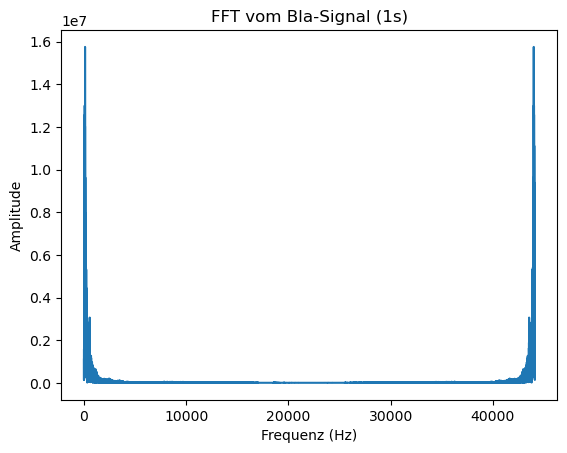

In [99]:
blaFT = np.abs(np.fft.fft(blaS))
plt.plot(blaFT)
freq = np.argmax(blaFT[0: int(samples /2)])
print(f"Grundfrequenz: {freq} Hz")


plt.ylabel('Amplitude')
plt.xlabel('Frequenz (Hz)')
plt.title("FFT vom Bla-Signal (1s)")
plt.show()

#### 2 d) Windowing vom Sprachsignal

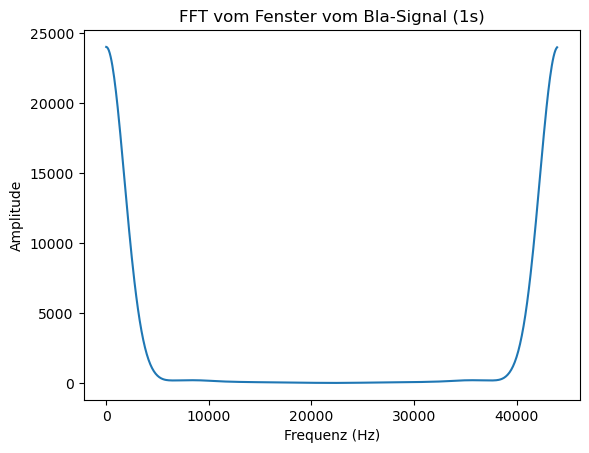

Grundfrequenz: 0 Hz +- 172 Hz


In [137]:
winSize = 512
winSizeH = winSize // 2
window = signal.windows.gaussian(winSize, std=4)

wAnz = samples // winSize
windowedBla = np.full((wAnz, winSize), 0, dtype=float)
fftWinBla = np.full((wAnz, winSize), 0, dtype=float)
midWinFFT = np.full( winSize, 0, dtype=float)

for winIndx in range(0, wAnz):
    winStart = winIndx * winSizeH
    windowedBla[winIndx] = blaS[winStart : winStart + winSize] * window
    fftWinBla[winIndx] = np.abs(np.fft.fft(windowedBla[winIndx])) ** 2
    midWinFFT += fftWinBla[winIndx]

midWinFFT = np.sqrt(midWinFFT / wAnz)
plt.plot(np.arange(winSize) * wAnz, midWinFFT)
plt.ylabel('Amplitude')
plt.xlabel('Frequenz (Hz)')
plt.title('FFT vom Fenster vom Bla-Signal (1s)')
plt.show()

freq = np.argmax(midWinFFT[0: int(winSize //2)])
print(f"Grundfrequenz: {freq} Hz +- 172 Hz")


## Aufgabe 3: Spracherkennung
### 3a) Referenzspektren

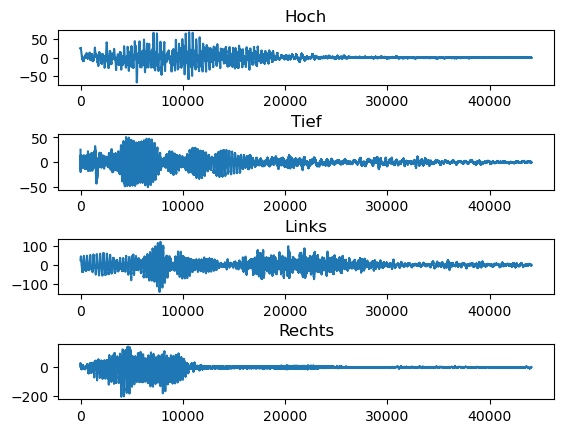

In [222]:
def meanFile(x):
    time = samples * 5 # 5s rec time
    file = np.full((5, samples), 0, dtype=float)
    for i in range(0, 5):
        f = np.load(f"{absPath}/spracherkennung/{x}{i}.npy")[25000: time]
        stIndx = firstOverVal(f, 25)
        file[i] = f[stIndx : stIndx + samples]
    return np.mean(file,axis=0)

fig, splt = plt.subplots(4)
hoch = meanFile("hoch")
tief = meanFile("tief")
links = meanFile("links")
rechts = meanFile("rechts")

splt[0].plot(hoch)
splt[1].plot(tief)
splt[2].plot(links)
splt[3].plot(rechts)

splt[0].set_title("Hoch")
splt[1].set_title("Tief")
splt[2].set_title("Links")
splt[3].set_title("Rechts")
plt.subplots_adjust(hspace=0.9)
plt.show()

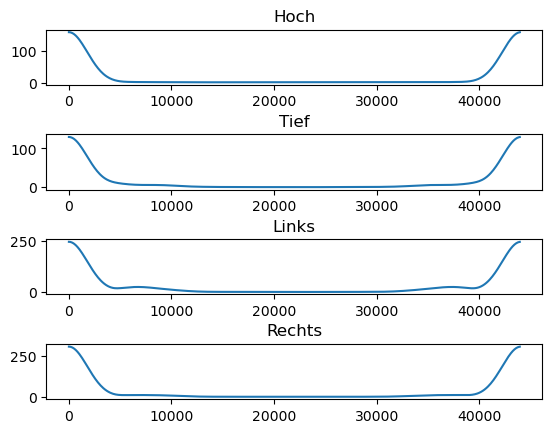

In [245]:
def windowFFT(arr):
    midFFT = 0
    for winIndx in range(0, wAnz):
        winStart = winIndx * winSizeH
        windowed = arr[winStart : winStart + winSize] * window
        fftArr = np.abs(np.fft.fft(windowed)) ** 2
        midFFT += fftArr
    return np.sqrt(midFFT / wAnz)

fig, splt = plt.subplots(4)
fftHoch = windowFFT(hoch)
fftTief = windowFFT(tief)
fftLinks = windowFFT(links)
fftRechts = windowFFT(rechts)
fftArray = np.array([fftHoch, fftTief, fftLinks, fftRechts])

x = np.arange(winSize) * wAnz
splt[0].plot(x, fftHoch)
splt[1].plot(x, fftTief)
splt[2].plot(x, fftLinks)
splt[3].plot(x, fftRechts)
splt[0].set_title("Hoch")
splt[1].set_title("Tief")
splt[2].set_title("Links")
splt[3].set_title("Rechts")
plt.subplots_adjust(hspace=0.9)
plt.show()

In [248]:
def corrcoeff(f, g):
    ofg = 0
    of = 0
    og = 0
    mf = np.mean(f)
    mg = np.mean(g)
    for i in np.arange(f.size):
        of += (f[i] - mf) ** 2
        og += (g[i] - mg) ** 2
        ofg += (f[i] - mf) * (g[i] - mg)
    og /= g.size - 1
    of /= f.size - 1
    ofg /= f.size
    return ofg / np.sqrt(of * og)

print(f"Korrelation Hoch - Hoch: {corrcoeff(fftHoch, fftHoch)}")

Korrelation Hoch - Hoch: 0.998046875


#### 2 d) Spracherkenner

In [265]:
def greater(a, b, c, d):
    return a > b and a > c and a > d

def wortTester(arr):
    arrIndx = firstOverVal(arr, 25)
    arr = arr[arrIndx : arrIndx + samples]
    ftX = windowFFT(arr)
    h = corrcoeff(ftX, fftHoch)
    t = corrcoeff(ftX, fftTief)
    l = corrcoeff(ftX, fftLinks)
    r = corrcoeff(ftX, fftRechts)
    if greater(h, t, l, r): return 0
    if greater(t, h, l, r): return 1
    if greater(l, h ,t, r): return 2
    if greater(r, h, t, l): return 3
    return -1

correctT = 0
correctC = 0
for i in range(0, 5):
    ho = np.load(f"{absPath}/spracherkennung/tom/hocht{i}.npy")
    if wortTester(ho) == 0:
        correctT += 1
    ti = np.load(f"{absPath}/spracherkennung/tom/tieft{i}.npy")
    if wortTester(ho) == 1:
        correctT += 1
    ti = np.load(f"{absPath}/spracherkennung/tom/linkst{i}.npy")
    if wortTester(ho) == 2:
        correctT += 1
    ti = np.load(f"{absPath}/spracherkennung/tom/rechtst{i}.npy")
    if wortTester(ho) == 3:
        correctT += 1

    ho = np.load(f"{absPath}/spracherkennung/chris/hocht{i}.npy")
    if wortTester(ho) == 0:
        correctC += 1
    ti = np.load(f"{absPath}/spracherkennung/chris/tieft{i}.npy")
    if wortTester(ho) == 1:
        correctC += 1
    ti = np.load(f"{absPath}/spracherkennung/chris/linkst{i}.npy")
    if wortTester(ho) == 2:
        correctC += 1
    ti = np.load(f"{absPath}/spracherkennung/chris/rechtst{i}.npy")
    if wortTester(ho) == 3:
        correctC += 1
print(f"Spracherkennung auf Testdaten von Tom erfolgreich: {correctT * 100 / 20}%")
print(f"Spracherkennung auf Testdaten von Chris erfolgreich: {correctC * 100 / 20}%")

Spracherkennung auf Testdaten von Tom erfolgreich: 25.0%
Spracherkennung auf Testdaten von Chris erfolgreich: 25.0%
